In [1]:
%reload_ext autoreload
%autoreload 2

# 1. Downlad and Load AlphaDeep models

In [2]:
import os
import wget
if not os.path.exists('sandbox/test_files'):
    os.makedirs('sandbox/test_files')
def download_data(url, file_path):
    if not os.path.exists(file_path):
        wget.download(url, file_path)

from alphadeep.model.rt import evaluate_linear_regression, evaluate_linear_regression_plot

from alphadeep.pretrained_models import AlphaDeepModels

models = AlphaDeepModels()
models.load_installed_models()

In [3]:
ms2_model = models.ms2_model
ms2_model.get_parameter_num()

5351690

In [4]:
rt_model = models.rt_model
rt_model.get_parameter_num()

708224

In [5]:
ccs_model = models.ccs_model
ccs_model.get_parameter_num()

713452

# 2. Test ccs_model

In [6]:
from alphadeep.psm_reader.psm_reader import psm_reader_provider
import alphadeep.psm_reader.maxquant_reader
ccs_url = 'https://datashare.biochem.mpg.de/s/uTGa7PliZzRJU4g/download'
ccs = 'sandbox/test_files/PXD019086_Celegant_evidence.txt'
download_data(ccs_url, ccs)
mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(ccs)

D:\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## CCS prediction is very good

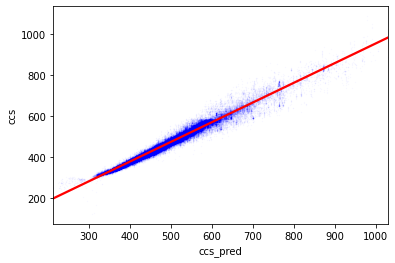

,R_square,R,slope,intercept,n_sample
0,0.97,0.984886,0.9591,-4.9418,141263.0


In [7]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA','charge'])['ccs'].median().reset_index()
predict_df = ccs_model.predict(psm_df)
evaluate_linear_regression_plot(predict_df, x='ccs_pred',y='ccs')
evaluate_linear_regression(predict_df, x='ccs_pred',y='ccs')

## Transfer learning on CCS can calibrate the slope as well

[Training] Epoch=1, Mean Loss=27.89161514043808
[Training] Epoch=2, Mean Loss=21.715563905239105
[Training] Epoch=3, Mean Loss=20.045990300178527
[Training] Epoch=4, Mean Loss=19.15612312555313
[Training] Epoch=5, Mean Loss=16.054387199878693
[Training] Epoch=6, Mean Loss=16.43987286090851
[Training] Epoch=7, Mean Loss=15.765071153640747
[Training] Epoch=8, Mean Loss=18.35345416069031
[Training] Epoch=9, Mean Loss=17.417391979694365
[Training] Epoch=10, Mean Loss=15.353533136844636
[Training] Epoch=11, Mean Loss=15.30859590768814
[Training] Epoch=12, Mean Loss=15.060989594459533
[Training] Epoch=13, Mean Loss=14.770723640918732
[Training] Epoch=14, Mean Loss=15.597211468219758
[Training] Epoch=15, Mean Loss=15.37189713716507
[Training] Epoch=16, Mean Loss=16.180544924736022
[Training] Epoch=17, Mean Loss=14.580160534381866
[Training] Epoch=18, Mean Loss=14.456783974170685
[Training] Epoch=19, Mean Loss=14.179139173030853
[Training] Epoch=20, Mean Loss=14.564631390571595


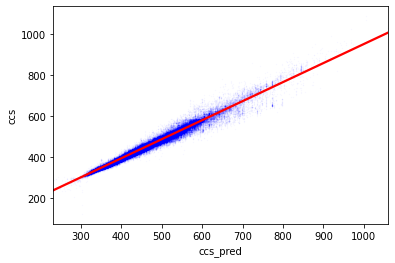

,R_square,R,slope,intercept,n_sample
0,0.971,0.985393,0.9272,23.9437,138204.0


In [8]:
import numpy as np
import pandas as pd
n_train = 5000

from alphadeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(psm_df, target='ccs', n_train=n_train, return_test_df=True)
ccs_model.train(train_df, verbose=True)
predict_df = ccs_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='ccs_pred',y='ccs')
evaluate_linear_regression(predict_df, x='ccs_pred',y='ccs')

<AxesSubplot:ylabel='Frequency'>

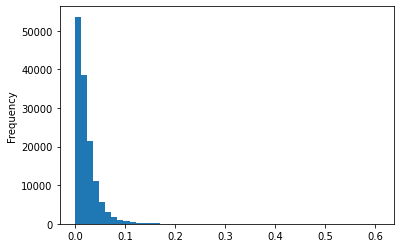

In [10]:
predict_df = ccs_model.ccs_to_mobility_pred(predict_df)
(predict_df.mobility-predict_df.mobility_pred).plot.hist(bins=50)

# 3. Test rt_model

## Test on Pan-human library

In [9]:
from alphadeep.psm_reader.psm_reader import psm_reader_provider
import alphadeep.psm_reader.dia_search_reader

phl_url = 'https://datashare.biochem.mpg.de/s/GyVnHxasODv5hYc/download'
phl = 'sandbox/test_files/phl004_canonical_s32_osw.tsv'
download_data(phl_url, phl)

mq_reader = psm_reader_provider.get_reader('openswath')
mq_reader.load(phl)

mq_reader = psm_reader_provider.get_reader('openswath')
mq_reader.load(phl)

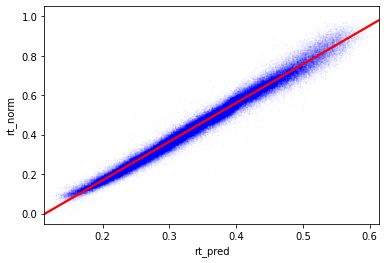

,R_square,R,slope,intercept,n_sample
0,0.978,0.988939,1.9592,-0.2226,204564.0


In [10]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()
predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Transfer learning on phl

In [11]:
import numpy as np
import pandas as pd
n_train = 5000

from alphadeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(
    psm_df, target='rt_norm', n_train=n_train, return_test_df=True
)
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.07622071931307967
[Training] Epoch=2, Mean Loss=0.029761343051425436
[Training] Epoch=3, Mean Loss=0.025052196155725556
[Training] Epoch=4, Mean Loss=0.01955638370815326
[Training] Epoch=5, Mean Loss=0.018614399458535692
[Training] Epoch=6, Mean Loss=0.014423437649384141
[Training] Epoch=7, Mean Loss=0.01639822235500271
[Training] Epoch=8, Mean Loss=0.01970085969448767
[Training] Epoch=9, Mean Loss=0.016333269992504607
[Training] Epoch=10, Mean Loss=0.013698181073943322
[Training] Epoch=11, Mean Loss=0.014735090884972702
[Training] Epoch=12, Mean Loss=0.013087888417596167
[Training] Epoch=13, Mean Loss=0.011984037071339448
[Training] Epoch=14, Mean Loss=0.012579783162271435
[Training] Epoch=15, Mean Loss=0.013607250431298533
[Training] Epoch=16, Mean Loss=0.012641716452146118
[Training] Epoch=17, Mean Loss=0.012340359305116263
[Training] Epoch=18, Mean Loss=0.013788277272727679
[Training] Epoch=19, Mean Loss=0.015200733471746471
[Training] Epoch=20, Mean

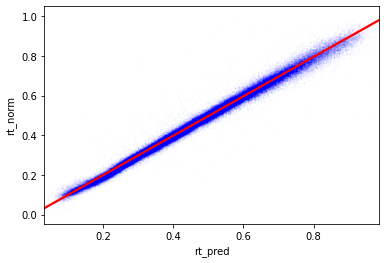

,R_square,R,slope,intercept,n_sample
0,0.99,0.994987,0.995,-0.0008,199564.0


In [12]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Test on non-linear gradient data

In [13]:
from alphadeep.pretrained_models import AlphaDeepModels

models = AlphaDeepModels()
models.load_installed_models()
rt_model = models.rt_model

nonlinear_url = 'https://datashare.biochem.mpg.de/s/HAjrz1ONA4vxCJL/download'
nonlinear = 'sandbox/test_files/PXD023848_nonlinear_gradient_evidence.txt'
download_data(nonlinear_url, nonlinear)

In [14]:
from alphadeep.psm_reader.psm_reader import psm_reader_provider
import alphadeep.psm_reader.maxquant_reader # register mq reader to psm_reader_provider

mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(nonlinear)

D:\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (52) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


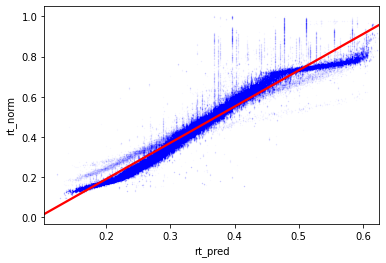

,R_square,R,slope,intercept,n_sample
0,0.936,0.967471,1.8045,-0.1707,254801.0


In [15]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()
for _, df_group in psm_df.groupby('raw_name'):
    psm_df.loc[df_group.index,'rt_norm'] = df_group.rt_norm / df_group.rt_norm.max()

predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Transfer learning for non-linear data

In [16]:
import numpy as np
import pandas as pd
n_train = 5000

from alphadeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(psm_df, target='rt_norm', n_train=n_train, return_test_df=True)
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.08282321545844659
[Training] Epoch=2, Mean Loss=0.037476165124621146
[Training] Epoch=3, Mean Loss=0.029633008588392
[Training] Epoch=4, Mean Loss=0.025033872311887067
[Training] Epoch=5, Mean Loss=0.023212736412787285
[Training] Epoch=6, Mean Loss=0.02503726010521253
[Training] Epoch=7, Mean Loss=0.02241671617883138
[Training] Epoch=8, Mean Loss=0.020598089155287314
[Training] Epoch=9, Mean Loss=0.020015784873603247
[Training] Epoch=10, Mean Loss=0.019589358964600623
[Training] Epoch=11, Mean Loss=0.02179163481849126
[Training] Epoch=12, Mean Loss=0.018639604405810434
[Training] Epoch=13, Mean Loss=0.018672296920647986
[Training] Epoch=14, Mean Loss=0.01706735303816505
[Training] Epoch=15, Mean Loss=0.020271752984860003
[Training] Epoch=16, Mean Loss=0.018388190187322788
[Training] Epoch=17, Mean Loss=0.02017430003541402
[Training] Epoch=18, Mean Loss=0.016514351627287958
[Training] Epoch=19, Mean Loss=0.016035174795736868
[Training] Epoch=20, Mean Loss

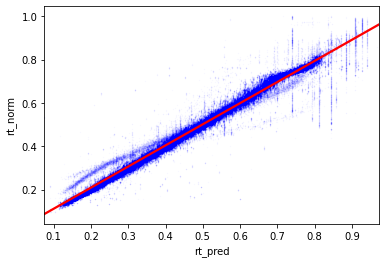

,R_square,R,slope,intercept,n_sample
0,0.973,0.986408,0.9746,0.0147,250291.0


In [17]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

<AxesSubplot:ylabel='Frequency'>

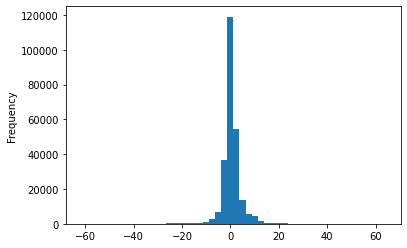

In [18]:
(predict_df.rt.max()*(predict_df.rt_norm-predict_df.rt_pred)).plot.hist(bins=50)

### There is an outlier raw file, resulting in some outlier predictions

In [19]:
for raw_name, group_df in psm_df.groupby('raw_name'):
    print(raw_name, 'gradient =', group_df.rt.max())

B07857_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-1 gradient = 138.8
B07859_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-2 gradient = 82.357
B07859_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-8 gradient = 138.36
B07861_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-3 gradient = 138.55
B07861_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-9 gradient = 139.29
B07863_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-10 gradient = 138.33
B07863_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-4 gradient = 138.86
B07865_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-5 gradient = 138.44
B07867_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-6 gradient = 139.05
B07869_Ap_WNE1_PRC-5228-Fendt_Sara_Shotgun-7 gradient = 138.64


## Test on short gradient data

In [20]:
from alphadeep.pretrained_models import AlphaDeepModels

models = AlphaDeepModels()
models.load_installed_models()
rt_model = models.rt_model

short_url = 'https://datashare.biochem.mpg.de/s/ASbXk0W4yvBNURI/download'
short_grad = 'sandbox/test_files/PXD016662_short_gradient_evidence.txt'
download_data(short_url, short_grad)

from alphadeep.psm_reader.psm_reader import psm_reader_provider
import alphadeep.psm_reader.maxquant_reader # register mq reader to psm_reader_provider

mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(short_grad)

D:\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (59,67) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
psm_df = mq_reader.psm_df#.groupby(['sequence','mods','mod_sites','nAA'])['rt_norm'].median().reset_index()

def create_raw_gradient_dict(psm_df):
    gradient_dict = {5: [], 11: [], 21: []}
    for raw_name, df_group in psm_df.groupby('raw_name'):
        rt_max = df_group.rt.max()
        if abs(rt_max-5) <= 2:
            gradient_dict[5].append(raw_name)
        elif abs(rt_max-11) <= 2:
            gradient_dict[11].append(raw_name)
        else:
            gradient_dict[21].append(raw_name)
    return gradient_dict
gradient_dict = create_raw_gradient_dict(mq_reader.psm_df)
def get_psm_df_by_gradient(psm_df, gradient=11):
    return psm_df[psm_df.raw_name.isin(gradient_dict[gradient])].copy()

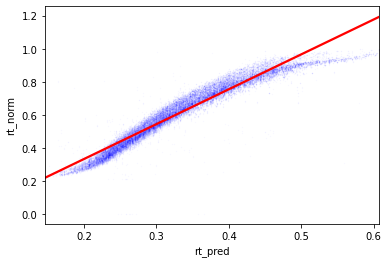

,R_square,R,slope,intercept,n_sample
0,0.931,0.964883,2.108,-0.0879,38027.0


In [22]:
psm_df = get_psm_df_by_gradient(mq_reader.psm_df, gradient=11)
for _, df_group in psm_df.groupby('raw_name'):
    psm_df.loc[df_group.index,'rt_norm'] = df_group.rt_norm / df_group.rt_norm.max()

predict_df = rt_model.predict(psm_df)

evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

## Transfer learning on short gradient

In [23]:
import numpy as np
import pandas as pd
n_train = 4000

from alphadeep.model.rt import uniform_sampling
train_df, test_df = uniform_sampling(psm_df, target='rt_norm', n_train=n_train, return_test_df=True)
rt_model.train(train_df, epoch=20, verbose=True, verbose_each_epoch=False)

[Training] Epoch=1, Mean Loss=0.170434911016907
[Training] Epoch=2, Mean Loss=0.046542691652263914
[Training] Epoch=3, Mean Loss=0.02975834041301693
[Training] Epoch=4, Mean Loss=0.0270392721252782
[Training] Epoch=5, Mean Loss=0.023223701172641345
[Training] Epoch=6, Mean Loss=0.017786109247910124
[Training] Epoch=7, Mean Loss=0.017997759434261493
[Training] Epoch=8, Mean Loss=0.01785121831510748
[Training] Epoch=9, Mean Loss=0.021269575293575014
[Training] Epoch=10, Mean Loss=0.01678608464343207
[Training] Epoch=11, Mean Loss=0.015695599879005127
[Training] Epoch=12, Mean Loss=0.017756896439407553
[Training] Epoch=13, Mean Loss=0.017506812180259398
[Training] Epoch=14, Mean Loss=0.020014725998044013
[Training] Epoch=15, Mean Loss=0.019365364313125612
[Training] Epoch=16, Mean Loss=0.016639834163444382
[Training] Epoch=17, Mean Loss=0.0133383581813957
[Training] Epoch=18, Mean Loss=0.015863767692020962
[Training] Epoch=19, Mean Loss=0.01310873566461461
[Training] Epoch=20, Mean Loss=0

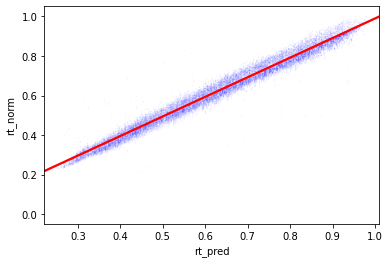

,R_square,R,slope,intercept,n_sample
0,0.97,0.984886,0.9901,-0.0003,34822.0


In [24]:
predict_df = rt_model.predict(test_df)
evaluate_linear_regression_plot(predict_df, x='rt_pred',y='rt_norm')
evaluate_linear_regression(predict_df, x='rt_pred',y='rt_norm')

<AxesSubplot:ylabel='Frequency'>

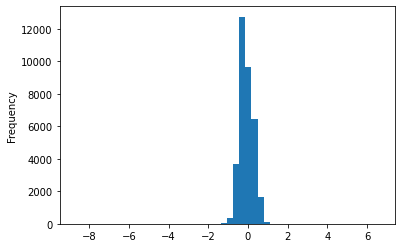

In [25]:
(predict_df.rt.max()*(predict_df.rt_norm-predict_df.rt_pred)).plot.hist(bins=50)

# 4. Predict spectral library

In [26]:
from alphadeep.spec_lib.predict_lib import PredictLib
predlib = PredictLib(
    models.ms2_model.charged_frag_types, models
)
predlib.precursor_df = mq_reader.psm_df
predlib.predict_rt_ccs()

100%|██████████| 67/67 [00:08<00:00,  7.92it/s]


In [27]:
predlib.precursor_df['instrument'] = 'timsTOF'
predlib.precursor_df['nce'] = 30 # always set as 30 for timsTOF
predlib.load_fragment_intensity_df()

100%|██████████| 67/67 [00:12<00:00,  5.22it/s]


In [28]:
predlib.precursor_df

,sequence,charge,rt,rt_norm,ccs,mobility,spec_idx,raw_name,score,proteins,...,mod_sites,precursor_mz,rt_pred,irt_pred,ccs_pred,mobility_pred,instrument,nce,frag_start_idx,frag_end_idx
0,AAAVPQR,2,5.2031,0.242083,<NA>,<NA>,4019,20190524_EXP1_Evo2_DBJ_LFQprot_SDS_500ng_15000...,51.036,Q00688,...,0,377.713945,0.390927,-5.535138,298.633942,0.732207,timsTOF,0.3,0,6
1,AAQLAIR,2,6.1190,0.284697,<NA>,<NA>,5071,20190524_EXP1_Evo2_DBJ_LFQprot_SDS_500ng_15000...,59.795,P62910,...,,371.732137,0.429958,2.307741,299.386993,0.733843,timsTOF,0.3,6,12
2,AAQLAIR,2,2.2269,0.103610,<NA>,<NA>,1046,20190830_EXP1_Evo1_DBJ_Dil-Ser-DDAFAIMS_HELA_5...,121.870,P62910,...,,371.732137,0.429959,2.307813,299.386993,0.733843,timsTOF,0.3,12,18
3,AAQLAIR,2,2.2564,0.104983,<NA>,<NA>,1003,20190830_EXP1_Evo1_DBJ_Dil-Ser-DDAFAIMS_HELA_5...,133.990,P62910,...,,371.732137,0.429958,2.307741,299.386993,0.733843,timsTOF,0.3,18,24
4,AAQLAIR,2,2.3230,0.108082,<NA>,<NA>,1069,20190830_EXP1_Evo1_DBJ_Dil-Ser-DDAFAIMS_HELA_5...,121.680,P62910,...,,371.732137,0.429959,2.307813,299.386993,0.733843,timsTOF,0.3,24,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391102,GQLASPSSQSAAASSLGPYGGAQPSASALSSYGGQAAAASSLNSYG...,5,16.5410,0.769599,<NA>,<NA>,18999,20190914_EXP1_Evo1_AMV_LFQPhos_200ug_30ul-TiIM...,134.910,Q96PK6,...,5,1383.832107,0.782265,73.099265,1182.505615,1.178648,timsTOF,0.3,5538892,5538964
391103,GQLASPSSQSAAASSLGPYGGAQPSASALSSYGGQAAAASSLNSYG...,6,16.4070,0.763365,<NA>,<NA>,18991,20190914_EXP1_Evo1_AMV_LFQPhos_200ug_30ul-TiIM...,67.855,Q96PK6,...,5;23;35;43,1153.853309,0.786179,73.885732,1239.406982,1.029471,timsTOF,0.3,5538964,5539036
391104,QPSWDPSPVSSTVPAPSPLSAAAVSPSKLPEDDEPPARPPPPPPAS...,6,18.2320,0.848276,<NA>,<NA>,21257,20190914_EXP1_Evo1_AMV_LFQPhos_200ug_30ul-TiIM...,31.865,Q9NQC3,...,25;27,1230.937032,0.848980,86.504609,1244.054199,1.033461,timsTOF,0.3,5539036,5539108
391105,VPALLLPPGPPVGGGGPGAPPSPPAVAAAAAAAGSSGAGVPGGAAA...,5,19.7670,0.919695,<NA>,<NA>,23097,20190914_EXP1_Evo1_AMV_LFQPhos_200ug_30ul-TiIM...,31.167,Q03164,...,22,1228.809982,0.865465,89.817170,1155.776489,1.151713,timsTOF,0.3,5539108,5539180


In [29]:
predlib.fragment_mz_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,114.054954,57.531115,641.372935,321.190105,0.000000,0.000000,0.000000,0.000000
1,185.092068,93.049672,570.335821,285.671548,0.000000,0.000000,0.000000,0.000000
2,256.129182,128.568229,499.298707,250.152991,0.000000,0.000000,0.000000,0.000000
3,355.197596,178.102436,400.230293,200.618785,0.000000,0.000000,0.000000,0.000000
4,452.250360,226.628818,303.177529,152.092403,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
5539254,6388.235644,3194.621460,459.292559,230.149917,6290.258749,3145.633012,361.315663,181.161470
5539255,6501.319708,3251.163492,346.208495,173.607885,6403.342813,3202.175044,248.231599,124.619438
5539256,6572.356822,3286.682049,275.171381,138.089329,6474.379926,3237.693601,177.194486,89.100881
5539257,6629.378286,3315.192781,218.149917,109.578597,6531.401390,3266.204333,120.173022,60.590149


In [18]:
predlib.fragment_intensity_df

,b_z1,b_z2,y_z1,y_z2,b_modloss_z1,b_modloss_z2,y_modloss_z1,y_modloss_z2
0,0.000000,0.0,0.049143,0.0,0.0,0.0,0.0,0.0
1,0.013662,0.0,0.472650,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.999904,0.0,0.0,0.0,0.0,0.0
3,0.012302,0.0,0.700725,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.097460,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2227056,0.000000,0.0,0.033926,0.0,0.0,0.0,0.0,0.0
2227057,0.000000,0.0,0.002669,0.0,0.0,0.0,0.0,0.0
2227058,0.000000,0.0,0.033581,0.0,0.0,0.0,0.0,0.0
2227059,0.000000,0.0,0.050408,0.0,0.0,0.0,0.0,0.0
